In [1]:
from typing import List, Set
from enum import Enum
import abc
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from queue import Queue


## Base classes for solving general CSP

### Base variable class

In [2]:
class Variable():
    steps = 0
    
    def __init__(self, possible_values: Enum, ID: str = None):
        self.ID = ID
        self.value = None
        self.possible_values = set([val for val in possible_values])
        self.previous_possible_values = set([val for val in possible_values])
        
    def set_value(self, value, count = True):
        self.value = value
        
        if value and count:
            Variable.steps = Variable.steps + 1
        
    def __str__(self):
        return f'{self.value}'

### Base class representing any CSP and its solution

In [3]:
class CSP():
    
    def __init__(self, X: List[Variable], D: Enum, C):
        self.variables = X
        self.values = D
        self.condition = C
        self.solved = False
                   
    def solve(self):
        self.solved = False
        Variable.steps = 0
        
        print("---------------------------------")
        print("    setting variables to None    ")
        print("---------------------------------")
        
        for v in self.variables:
            v.set_value(None)

        print("---------------------------------")
        print("            colouring            ")
        print("---------------------------------")
        
        answer =  self.algorithm()
        
        self.solved = answer
        self.print_stats()
        
        return answer
    
    @abc.abstractmethod
    def algorithm(self):
        pass

        
    def print_stats(self):
        print("---------------------------------")
        print("              stats              ")
        print("---------------------------------")
        
        print(f"Solved: {self.solved}")
        print(f"Steps: {Variable.steps}")
            
    def totally_assigned(self):
        for v in self.variables:
            if not v.value:
                return False
        
        return True
    
    def get_unassigned(self):
        for v in self.variables:
            if v.value is None:
                return v
    
    def print_graph(self):
        for v in self.variables:
            print(v)
            
    def get_dataframe(self):
        df = pd.DataFrame()
        
        df['values'] = [v.value.value if v.value else 'WHITE' for v in self.variables]
        df['id'] = [v.ID for v in self.variables]
        
        return df

## Classes and methods for the graph colouring problem

### State variable class

In [4]:
class State(Variable):
    
    def __init__(self, name: str, possible_values: Enum, ID: str = None):
        super(self.__class__, self).__init__(possible_values, ID)
        
        self.name = name
        self.neighbours = []
    
    def add_neigbours(self, neighbours: List):
        self.neighbours = neighbours
        
    def set_value(self, value, count = True):
        if count and (self.value or value):
            print(f'{self.name}: {self.value} -> {value}')
        
        super(State, self).set_value(value, count)
    
    def __str__(self):
        return f'-------{self.name}-------\n' \
        f'Colour: {self.value}\n' \
        f'Neigbours: {[state.name for state in self.neighbours]}'




### Enum for the colours in the graph

In [5]:
class Colour(Enum):
    
    RED = 'RED'
    GREEN = 'GREEN'
    BLUE = 'BLUE'

### Condition deciding if the graph is valid

In [6]:
def colour_graph_cond(cities: List[State]):
    satisfied = True
    conflicts = set() 
    
    for state in states:
        for neighbour in state.neighbours:
            if state.value == neighbour.value and state.value and neighbour.value:
                satisfied = False
                conflicts.add(neighbour)
                
    return satisfied, conflicts

### Classed for CSP algorithms

In [7]:
class Backtracking(CSP):
                         
    def algorithm(self):
        if self.totally_assigned():
            answer = True

        else:
            v = self.get_unassigned()
            answer = False

            for val in v.possible_values:
                if answer is False:
                    v.set_value(val)
                    
                    satisfied, _ = self.condition(self.variables)
                    if satisfied:
                        answer = self.algorithm()
                    else:
                        v.set_value(None)
                
            if answer is False:
                v.set_value(None)
                     
        return answer

        

In [8]:
class Backjumping(CSP):
        
    def algorithm(self):
        if self.totally_assigned():
            return True, set()
        
        else:
            v = self.get_unassigned()
            answer = False
            conflict_set = set()
            
            for val in v.possible_values:
                v.set_value(val)
                
                satisfied, conflicts = self.condition(self.variables)
                if satisfied:
                    answer, new_conflicts = self.algorithm()
                else:
                    new_conflicts = conflicts
                    v.set_value(None)
                                                    
                if answer is True:
                    return answer, set()
                elif v not in new_conflicts:
                    return False, new_conflicts
                else:
                    new_conflicts.remove(v)
                    conflict_set = conflict_set.union(new_conflicts)
            
            if answer is False:
                v.set_value(None)
                    
            return False, conflict_set
    
        
        

In [9]:
class BacktrackingConsistency(CSP):
                            
    def algorithm(self):
        if self.totally_assigned():
            answer = True

        else:
            v = self.get_unassigned()
            answer = False

            for val in v.possible_values:
                if answer is False:
                    v.set_value(val)
                    
                    satisfied, _ = self.condition(self.variables)
                    if satisfied:
                        inferences = self.arc_consisentcy()
                        
                        if inferences:  
                            answer = self.algorithm()
                            
                            if answer:
                                return answer
                    else:
                        v.set_value(None)
                     
        if answer is False:
                v.set_value(None)
                
        return answer
        
    def get_pairs(self):
        q = Queue()
        
        for v in self.variables:
            for neighbour in v.neighbours:
                q.put((v, neighbour))
                
        return q
        
    def revise(self, v1, v2):
        revised = False
        
        for val1 in v1.possible_values:
            satisfies = False
            for val2 in v2.possible_values:
                if val1 != val2:
                    satisfies = True
            
            if not satisfies:
                v1.possible_values.remove(val1)
                revised = True
        
        return revised
    
    def revert_inference(self):        
        for v in self.variables:
            v.possible_values = v.previous_possible_values.copy()
    
    def commit_inference(self):        
        for v in self.variables:
            v.previous_possible_values = v.possible_values.copy()
    
    def arc_consisentcy(self):
        q = self.get_pairs()
        
        while not q.empty():
            v1, v2 = q.get()
            
            if self.revise(v1, v2):
                if not len(v1.possible_values):
                    self.revert_inference()
                    return False
                
                for neighbour in v1.neighbours:
                    if neighbour is not v2:
                        q.put(neighbour, v1)
                        
        self.commit_inference()
        return True
    
                
            
            

In [10]:
class DynamicBacktracking(CSP):
            
    def algorithm(self):
        culprits = {}
        assigned_order = []
        
        for v in self.variables:
            for val in v.possible_values:
                culprits[(v, val)] = None
                
        while not self.totally_assigned():
            v = self.get_unassigned()
            
            for val in v.possible_values:
                if culprits[(v, val)] is None:
                    v.set_value(val, False)
                    satisfied, conflicts = self.condition(self.variables)
                    
                    if not satisfied:
                        conflicts.remove(v)
                        culprits[(v, val)] = conflicts
                    
                    v.set_value(None, False)
                    
            val_to_set = None
            for val in v.possible_values:
                if culprits[(v,val)] is None:
                    val_to_set = val
                    break
            
            if val_to_set:
                v.set_value(val_to_set)
                assigned_order.insert(0, v)
                
            else:
                conflict_set = set()
                
                for val in v.possible_values:
                    conflict_set = conflict_set.union(culprits[(v,val)])
                    
                if len(conflict_set) == 0:
                    return False
                else:
                    w = self.get_most_recently_bound(assigned_order, conflict_set)
                    for u in self.variables:
                        for u_val in u.possible_values:
                            if culprits[(u, u_val)] and w in culprits[(u, u_val)]:
                                culprits[(u, u_val)] = None
                    
                    conflict_set.remove(w)
                    culprits[(w, w.value)] = conflict_set
                    w.set_value(None)
        
        return True
                           
        
    def get_most_recently_bound(self, order: List, variables: Set): 
        for i in range(len(order)):
            if order[i] in variables:
                return order[i]
        

### Helper functions

In [11]:
def plot_map(locations, values):
    df = locations.set_index('STATE_CODE').join(values.set_index('id'))
    
    df.plot(color=df['values'], figsize=(15,8))
    plt.show()

In [12]:
def print_set(states):
    print(len(states))
    for s in states:
        print(s.name)

### Representation of the Australian states and loading map data

In [13]:
df_states = gpd.read_file('states.geojson')

df_states

STATE_CODE                    STATE_NAME  \
0          1               New South Wales   
1          2                      Victoria   
2          3                    Queensland   
3          4               South Australia   
4          5             Western Australia   
5          6                      Tasmania   
6          7            Northern Territory   
7          8  Australian Capital Territory   

                                            geometry  
0  MULTIPOLYGON (((159.10542 -31.56399, 159.09775...  
1  MULTIPOLYGON (((145.13189 -38.39069, 145.12993...  
2  MULTIPOLYGON (((141.66351 -15.00396, 141.59026...  
3  MULTIPOLYGON (((138.50022 -34.84357, 138.51080...  
4  MULTIPOLYGON (((113.39418 -26.39303, 113.38230...  
5  MULTIPOLYGON (((148.48189 -40.43493, 148.47286...  
6  MULTIPOLYGON (((130.51789 -12.73105, 130.51753...  
7  POLYGON ((149.39928 -35.31918, 149.35213 -35.3...

In [14]:
nsw = State('New South Wales', Colour, '1')
vic = State('Victoria', Colour, '2')
sa = State('South Australia', Colour, '4')
tas = State('Tasmania', Colour, '6')
nt = State('Northern Territory', Colour, '7')
wa = State('Western Australia', Colour, '5')
qld = State('Queensland', Colour, '3')
act = State('Australian Capital Territory', Colour, '8')

nsw.add_neigbours([vic, qld, sa, act])
vic.add_neigbours([nsw, sa])
sa.add_neigbours([vic, nsw, nt, wa, qld])
nt.add_neigbours([wa, sa, qld])
wa.add_neigbours([sa, nt])
qld.add_neigbours([nsw, nt, sa])
act.add_neigbours([nsw])

In [15]:
states = [act, vic, sa, tas, nt, wa, qld, nsw]
variables = Colour
condition = colour_graph_cond

### Backtracking

---------------------------------
    setting variables to None    
---------------------------------
---------------------------------
            colouring            
---------------------------------
Australian Capital Territory: None -> Colour.BLUE
Victoria: None -> Colour.BLUE
South Australia: None -> Colour.BLUE
South Australia: Colour.BLUE -> None
South Australia: None -> Colour.GREEN
Tasmania: None -> Colour.BLUE
Northern Territory: None -> Colour.BLUE
Western Australia: None -> Colour.BLUE
Western Australia: Colour.BLUE -> None
Western Australia: None -> Colour.GREEN
Western Australia: Colour.GREEN -> None
Western Australia: None -> Colour.RED
Queensland: None -> Colour.BLUE
Queensland: Colour.BLUE -> None
Queensland: None -> Colour.GREEN
Queensland: Colour.GREEN -> None
Queensland: None -> Colour.RED
New South Wales: None -> Colour.BLUE
New South Wales: Colour.BLUE -> None
New South Wales: None -> Colour.GREEN
New South Wales: Colour.GREEN -> None
New South Wales: None -> Co

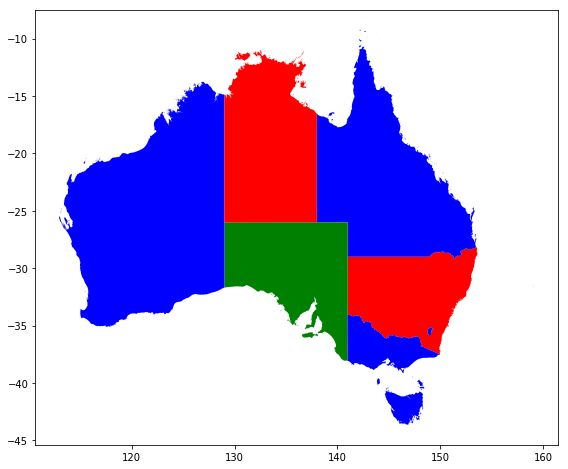

In [16]:
backtracking = Backtracking(states, variables, condition)
backtracking.solve()

plot_map(df_states, backtracking.get_dataframe())

### Backjumping

---------------------------------
    setting variables to None    
---------------------------------
Australian Capital Territory: Colour.BLUE -> None
Victoria: Colour.BLUE -> None
South Australia: Colour.GREEN -> None
Tasmania: Colour.BLUE -> None
Northern Territory: Colour.RED -> None
Western Australia: Colour.BLUE -> None
Queensland: Colour.BLUE -> None
New South Wales: Colour.RED -> None
---------------------------------
            colouring            
---------------------------------
Australian Capital Territory: None -> Colour.BLUE
Victoria: None -> Colour.BLUE
South Australia: None -> Colour.BLUE
South Australia: Colour.BLUE -> None
South Australia: None -> Colour.GREEN
Tasmania: None -> Colour.BLUE
Northern Territory: None -> Colour.BLUE
Western Australia: None -> Colour.BLUE
Western Australia: Colour.BLUE -> None
Western Australia: None -> Colour.GREEN
Western Australia: Colour.GREEN -> None
Western Australia: None -> Colour.RED
Queensland: None -> Colour.BLUE
Queensland: 

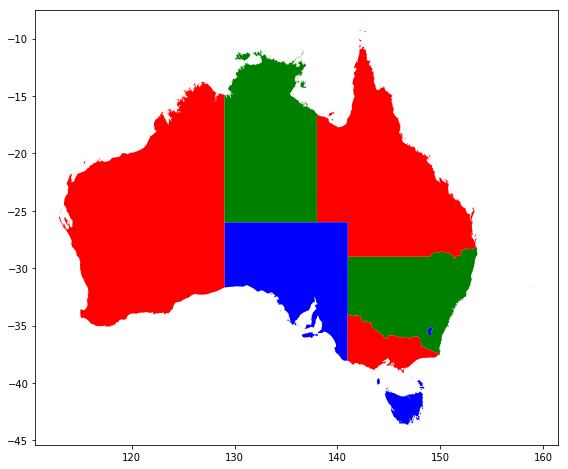

In [17]:
backjumping = Backjumping(states, variables, condition)
backjumping.solve()

plot_map(df_states, backjumping.get_dataframe())

### Backtracking with arc consistency

---------------------------------
    setting variables to None    
---------------------------------
Australian Capital Territory: Colour.BLUE -> None
Victoria: Colour.RED -> None
South Australia: Colour.BLUE -> None
Tasmania: Colour.BLUE -> None
Northern Territory: Colour.GREEN -> None
Western Australia: Colour.RED -> None
Queensland: Colour.RED -> None
New South Wales: Colour.GREEN -> None
---------------------------------
            colouring            
---------------------------------
Australian Capital Territory: None -> Colour.BLUE
Victoria: None -> Colour.BLUE
South Australia: None -> Colour.BLUE
South Australia: Colour.BLUE -> None
South Australia: None -> Colour.GREEN
Tasmania: None -> Colour.BLUE
Northern Territory: None -> Colour.BLUE
Western Australia: None -> Colour.BLUE
Western Australia: Colour.BLUE -> None
Western Australia: None -> Colour.GREEN
Western Australia: Colour.GREEN -> None
Western Australia: None -> Colour.RED
Queensland: None -> Colour.BLUE
Queensland: 

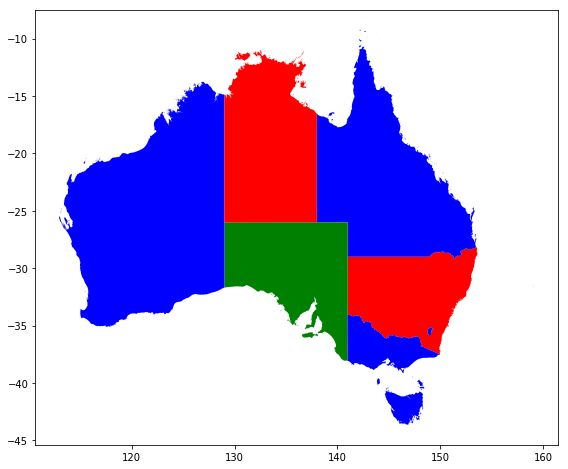

In [18]:
backtracking_consistency = BacktrackingConsistency(states, variables, condition)
backtracking_consistency.solve()

plot_map(df_states, backtracking_consistency.get_dataframe())

### Dynamic Backtracking

---------------------------------
    setting variables to None    
---------------------------------
Australian Capital Territory: Colour.BLUE -> None
Victoria: Colour.BLUE -> None
South Australia: Colour.GREEN -> None
Tasmania: Colour.BLUE -> None
Northern Territory: Colour.RED -> None
Western Australia: Colour.BLUE -> None
Queensland: Colour.BLUE -> None
New South Wales: Colour.RED -> None
---------------------------------
            colouring            
---------------------------------
Australian Capital Territory: None -> Colour.BLUE
Victoria: None -> Colour.BLUE
South Australia: None -> Colour.GREEN
Tasmania: None -> Colour.BLUE
Northern Territory: None -> Colour.BLUE
Western Australia: None -> Colour.RED
Queensland: None -> Colour.RED
Queensland: Colour.RED -> None
Northern Territory: Colour.BLUE -> None
Western Australia: Colour.RED -> None
Northern Territory: None -> Colour.RED
Western Australia: None -> Colour.BLUE
Queensland: None -> Colour.BLUE
New South Wales: None -> C

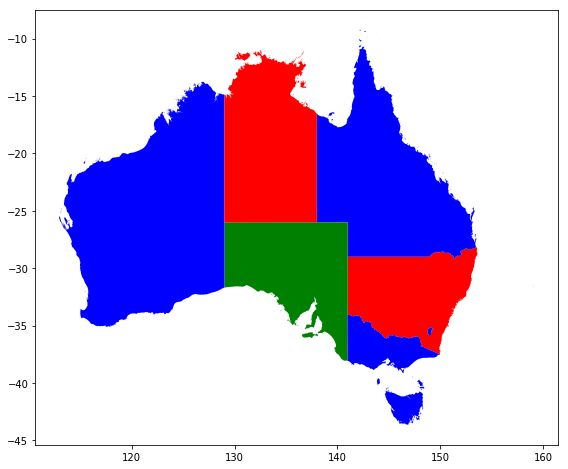

In [19]:
dynamic_backtracking = DynamicBacktracking(states, variables, condition)
dynamic_backtracking.solve()

plot_map(df_states, dynamic_backtracking.get_dataframe())